<a href="https://colab.research.google.com/github/mohsina680/BuildablesDataScienceFellowship/blob/main/simple_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Movie Recommendation System
## Using Collaborative Filtering with Matrix Factorization (ALS)

This notebook demonstrates a basic recommendation system

## 1. Setup and Data Loading

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load MovieLens dataset (using a sample dataset)
# For this example, we'll create a synthetic dataset similar to MovieLens

# Create synthetic user-item interaction data
np.random.seed(42)
n_users = 100
n_movies = 50
n_ratings = 1000

# Generate random user-movie ratings
users = np.random.randint(1, n_users + 1, n_ratings)
movies = np.random.randint(1, n_movies + 1, n_ratings)
ratings = np.random.randint(1, 6, n_ratings)

# Create DataFrame
df_ratings = pd.DataFrame({
    'user_id': users,
    'movie_id': movies,
    'rating': ratings
})

# Remove duplicates and keep the first occurrence
df_ratings = df_ratings.drop_duplicates(subset=['user_id', 'movie_id'])

# Create movie titles
movie_titles = [f"Movie_{i}" for i in range(1, n_movies + 1)]
df_movies = pd.DataFrame({
    'movie_id': range(1, n_movies + 1),
    'title': movie_titles
})

print(f"Dataset created with {len(df_ratings)} ratings")
print(f"Number of unique users: {df_ratings['user_id'].nunique()}")
print(f"Number of unique movies: {df_ratings['movie_id'].nunique()}")
print("\nFirst few ratings:")
print(df_ratings.head())

Dataset created with 902 ratings
Number of unique users: 100
Number of unique movies: 50

First few ratings:
   user_id  movie_id  rating
0       52        34       4
1       93        47       2
2       15         8       2
3       72        40       2
4       61        49       2


## 2. Exploratory Data Analysis

Rating distribution:
rating
1    167
2    196
3    159
4    195
5    185
Name: count, dtype: int64


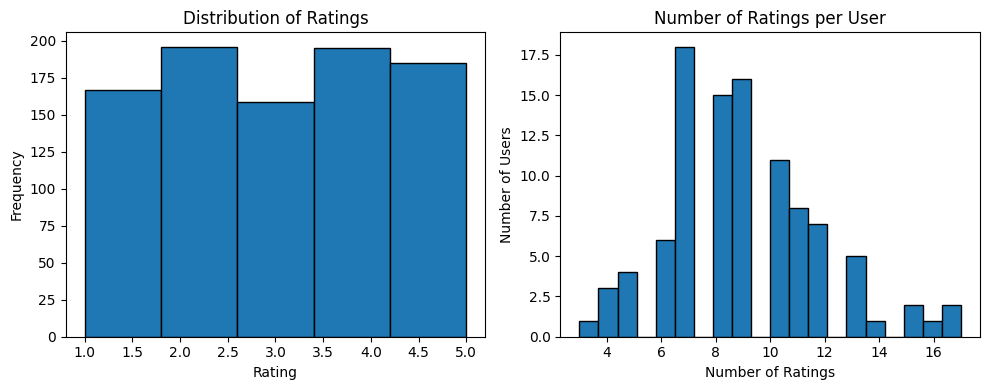


Data sparsity: 81.96%


In [3]:
# Basic statistics
print("Rating distribution:")
print(df_ratings['rating'].value_counts().sort_index())

# Plot rating distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(df_ratings['rating'], bins=5, edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
user_counts = df_ratings.groupby('user_id').size()
plt.hist(user_counts, bins=20, edgecolor='black')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')

plt.tight_layout()
plt.show()

# Calculate sparsity
sparsity = 1 - (len(df_ratings) / (df_ratings['user_id'].nunique() * df_ratings['movie_id'].nunique()))
print(f"\nData sparsity: {sparsity:.2%}")

## 3. Data Preparation

In [4]:
# Create user-item matrix
user_item_matrix = df_ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

print(f"User-item matrix shape: {user_item_matrix.shape}")
print(f"Matrix sparsity: {(user_item_matrix == 0).sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]):.2%}")

# Split data into training and testing
train_data, test_data = train_test_split(df_ratings, test_size=0.2, random_state=42)

print(f"\nTraining set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")

# Create training matrix
train_matrix = train_data.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
train_matrix = train_matrix.reindex(index=user_item_matrix.index, columns=user_item_matrix.columns, fill_value=0)

User-item matrix shape: (100, 50)
Matrix sparsity: 81.96%

Training set size: 721
Test set size: 181


## 4. Build Recommendation System using Matrix Factorization (SVD)

In [5]:
class MatrixFactorizationRecommender:
    def __init__(self, k=10):
        self.k = k  # Number of latent factors
        self.user_factors = None
        self.item_factors = None
        self.global_mean = None

    def fit(self, user_item_matrix):
        """Fit the model using SVD"""
        # Calculate global mean
        self.global_mean = user_item_matrix.values[user_item_matrix.values > 0].mean()

        # Center the data by subtracting mean
        centered_matrix = user_item_matrix.values.copy()
        centered_matrix[centered_matrix > 0] -= self.global_mean

        # Perform SVD
        U, sigma, Vt = svds(centered_matrix, k=self.k)

        # Store factors
        self.user_factors = U
        self.item_factors = Vt.T
        self.sigma = np.diag(sigma)

        # Reconstruct the matrix
        self.predicted_ratings = np.dot(np.dot(U, self.sigma), Vt) + self.global_mean

        return self

    def predict(self, user_id, movie_id, user_item_matrix):
        """Predict rating for a specific user-movie pair"""
        try:
            user_idx = user_item_matrix.index.get_loc(user_id)
            movie_idx = user_item_matrix.columns.get_loc(movie_id)
            return self.predicted_ratings[user_idx, movie_idx]
        except:
            return self.global_mean

    def recommend_movies(self, user_id, user_item_matrix, n_recommendations=5):
        """Recommend top N movies for a user"""
        try:
            user_idx = user_item_matrix.index.get_loc(user_id)
            user_ratings = user_item_matrix.loc[user_id]

            # Get predicted ratings for all movies
            predicted_ratings = self.predicted_ratings[user_idx]

            # Get movies the user hasn't rated
            unrated_movies = user_ratings[user_ratings == 0].index

            # Get predictions for unrated movies
            recommendations = []
            for movie_id in unrated_movies:
                movie_idx = user_item_matrix.columns.get_loc(movie_id)
                pred_rating = predicted_ratings[movie_idx]
                recommendations.append((movie_id, pred_rating))

            # Sort by predicted rating and return top N
            recommendations.sort(key=lambda x: x[1], reverse=True)
            return recommendations[:n_recommendations]
        except:
            return []

# Train the model
recommender = MatrixFactorizationRecommender(k=10)
recommender.fit(train_matrix)

print("Model trained successfully!")

Model trained successfully!


## 5. Model Evaluation

Root Mean Square Error (RMSE): 1.389
Mean Absolute Error (MAE): 1.209


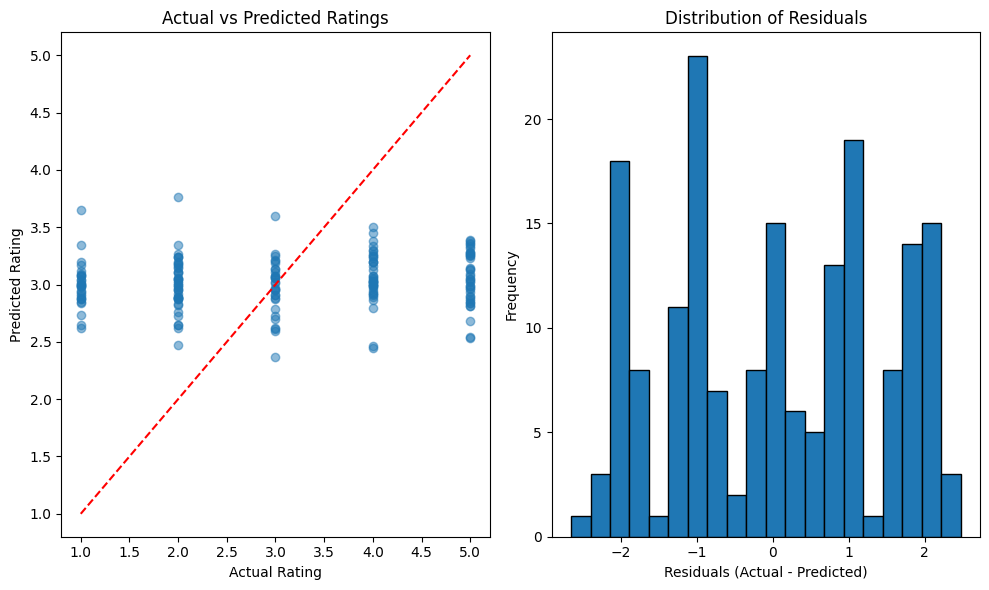

In [6]:
# Evaluate on test set
test_predictions = []
test_actual = []

for _, row in test_data.iterrows():
    user_id = row['user_id']
    movie_id = row['movie_id']
    actual_rating = row['rating']

    predicted_rating = recommender.predict(user_id, movie_id, train_matrix)

    test_predictions.append(predicted_rating)
    test_actual.append(actual_rating)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_actual, test_predictions))
mae = np.mean(np.abs(np.array(test_actual) - np.array(test_predictions)))

print(f"Root Mean Square Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")

# Plot predictions vs actual
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.scatter(test_actual, test_predictions, alpha=0.5)
plt.plot([1, 5], [1, 5], 'r--')  # Perfect prediction line
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title('Actual vs Predicted Ratings')

plt.subplot(1, 2, 2)
residuals = np.array(test_actual) - np.array(test_predictions)
plt.hist(residuals, bins=20, edgecolor='black')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

plt.tight_layout()
plt.show()

## 6. Generate Recommendations

In [7]:
# Generate recommendations for sample users
sample_users = df_ratings['user_id'].unique()[:5]

print("Movie Recommendations:")
print("=" * 50)

for user_id in sample_users:
    print(f"\nRecommendations for User {user_id}:")
    recommendations = recommender.recommend_movies(user_id, user_item_matrix, n_recommendations=5)

    if recommendations:
        for i, (movie_id, pred_rating) in enumerate(recommendations, 1):
            movie_title = df_movies[df_movies['movie_id'] == movie_id]['title'].iloc[0]
            print(f"{i}. {movie_title} (Predicted Rating: {pred_rating:.2f})")
    else:
        print("No recommendations available")

    # Show what the user has already rated
    user_ratings = df_ratings[df_ratings['user_id'] == user_id].merge(df_movies, on='movie_id')
    print(f"\nUser {user_id} has rated:")
    for _, row in user_ratings.head(3).iterrows():
        print(f"  - {row['title']}: {row['rating']}")
    if len(user_ratings) > 3:
        print(f"  ... and {len(user_ratings) - 3} more movies")

Movie Recommendations:

Recommendations for User 52:
1. Movie_29 (Predicted Rating: 3.64)
2. Movie_45 (Predicted Rating: 3.60)
3. Movie_32 (Predicted Rating: 3.60)
4. Movie_23 (Predicted Rating: 3.42)
5. Movie_3 (Predicted Rating: 3.39)

User 52 has rated:
  - Movie_34: 4
  - Movie_15: 4
  - Movie_8: 1
  ... and 8 more movies

Recommendations for User 93:
1. Movie_49 (Predicted Rating: 3.53)
2. Movie_27 (Predicted Rating: 3.45)
3. Movie_1 (Predicted Rating: 3.41)
4. Movie_21 (Predicted Rating: 3.40)
5. Movie_32 (Predicted Rating: 3.37)

User 93 has rated:
  - Movie_47: 2
  - Movie_50: 1
  - Movie_40: 1
  ... and 7 more movies

Recommendations for User 15:
1. Movie_50 (Predicted Rating: 3.76)
2. Movie_27 (Predicted Rating: 3.44)
3. Movie_23 (Predicted Rating: 3.43)
4. Movie_30 (Predicted Rating: 3.41)
5. Movie_36 (Predicted Rating: 3.35)

User 15 has rated:
  - Movie_8: 2
  - Movie_6: 5
  - Movie_37: 2
  ... and 5 more movies

Recommendations for User 72:
1. Movie_33 (Predicted Rating: 

## 7. Popular Movies (Baseline Recommendation)

In [8]:
# Calculate most popular movies (baseline recommendation)
popular_movies = df_ratings.groupby('movie_id').agg({
    'rating': ['count', 'mean']
}).round(2)
popular_movies.columns = ['rating_count', 'avg_rating']
popular_movies = popular_movies.reset_index()

# Filter movies with at least 5 ratings and sort by average rating
popular_movies = popular_movies[popular_movies['rating_count'] >= 3]
popular_movies = popular_movies.sort_values('avg_rating', ascending=False)

# Merge with movie titles
popular_movies = popular_movies.merge(df_movies, on='movie_id')

print("Top 10 Most Popular Movies (Baseline Recommendations):")
print("=" * 60)
for i, row in popular_movies.head(10).iterrows():
    print(f"{row.name + 1}. {row['title']} - Avg Rating: {row['avg_rating']:.2f} ({row['rating_count']} ratings)")

Top 10 Most Popular Movies (Baseline Recommendations):
1. Movie_15 - Avg Rating: 3.52 (21 ratings)
2. Movie_4 - Avg Rating: 3.44 (18 ratings)
3. Movie_34 - Avg Rating: 3.44 (25 ratings)
4. Movie_25 - Avg Rating: 3.43 (23 ratings)
5. Movie_6 - Avg Rating: 3.41 (17 ratings)
6. Movie_5 - Avg Rating: 3.41 (17 ratings)
7. Movie_29 - Avg Rating: 3.41 (27 ratings)
8. Movie_50 - Avg Rating: 3.40 (15 ratings)
9. Movie_14 - Avg Rating: 3.33 (15 ratings)
10. Movie_39 - Avg Rating: 3.33 (15 ratings)


## 8. Model Summary and Insights

In [9]:
print("RECOMMENDATION SYSTEM SUMMARY")
print("=" * 50)
print(f"Dataset: {len(df_ratings)} ratings from {df_ratings['user_id'].nunique()} users for {df_ratings['movie_id'].nunique()} movies")
print(f"Algorithm: Matrix Factorization (SVD) with {recommender.k} latent factors")
print(f"Data Sparsity: {sparsity:.2%}")
print(f"Model Performance:")
print(f"  - RMSE: {rmse:.3f}")
print(f"  - MAE: {mae:.3f}")
print(f"\nKey Features:")
print("- Personalized recommendations based on user preferences")
print("- Handles sparse data through matrix factorization")
print("- Provides predicted ratings for unrated movies")
print("- Fallback to global average for new users/items")

print("\nPossible Improvements:")
print("- Use more sophisticated algorithms (ALS, Neural Collaborative Filtering)")
print("- Incorporate content-based features (genres, directors, etc.)")
print("- Implement hybrid approaches combining multiple techniques")
print("- Add temporal dynamics to capture changing preferences")
print("- Use deep learning models for complex pattern recognition")

RECOMMENDATION SYSTEM SUMMARY
Dataset: 902 ratings from 100 users for 50 movies
Algorithm: Matrix Factorization (SVD) with 10 latent factors
Data Sparsity: 81.96%
Model Performance:
  - RMSE: 1.389
  - MAE: 1.209

Key Features:
- Personalized recommendations based on user preferences
- Handles sparse data through matrix factorization
- Provides predicted ratings for unrated movies
- Fallback to global average for new users/items

Possible Improvements:
- Use more sophisticated algorithms (ALS, Neural Collaborative Filtering)
- Incorporate content-based features (genres, directors, etc.)
- Implement hybrid approaches combining multiple techniques
- Add temporal dynamics to capture changing preferences
- Use deep learning models for complex pattern recognition
